In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import requests
import time
import json
from requests_futures.sessions import FuturesSession
from collections import namedtuple

# Bay Area Bike Share System

### Preliminary Analysis 

data is obtained from:
http://www.bayareabikeshare.com/open-data

In [35]:
# read bike trip data

trp = pd.read_csv('data/trip.csv')
weather = pd.read_csv('data/weather.csv')
stations = pd.read_csv('data/station.csv')

In [ ]:
# calculate total trip count for each station

start_counts['station_id'] = start_counts.index
start_counts.columns = ['start counts', 'station_id']
end_counts['station_id'] = start_counts.index
end_counts.columns = ['end counts', 'station_id']

stations = stations.merge(start_counts)
stations = stations.merge(end_counts)
stations['total counts'] = stations['start counts'] + stations['end counts']

In [40]:
print 'total number of docks:', stations.dockcount.sum()
print 'total number of bikes:', trp['Bike #'].value_counts().shape[0]
# print trp['Subscription Type'].value_counts()

total number of docks: 1236
total number of bikes: 700


### Explore the daily trips

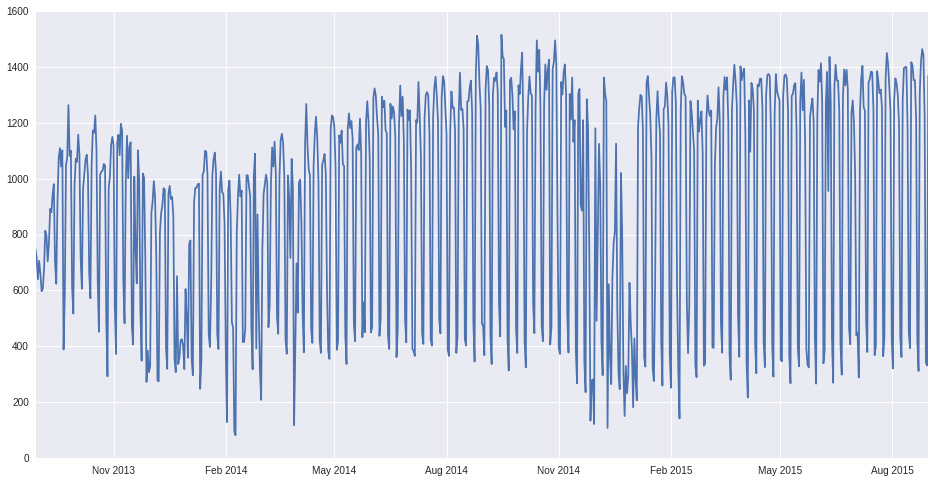

In [5]:
# plot bike trips for each day

trp['Start Date'] = pd.to_datetime(trp['Start Date'])
trp['End Date'] = pd.to_datetime(trp['End Date'])

nday = trp['Start Date'].dt.date.nunique()
stat_days = trp['Start Date'].dt.date.value_counts()

fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, sharey=True)
stat_days.plot()

In [6]:
# remove spurious trips that are too long, 
normal_trip = trp[trp.Duration < 10000]
normal_trip['minutes'] = normal_trip['Duration'] / 60 # in minutes

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### Explore the average trip time among annual subscribers and short-term customers

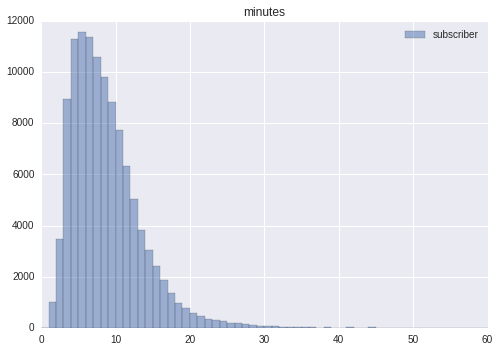

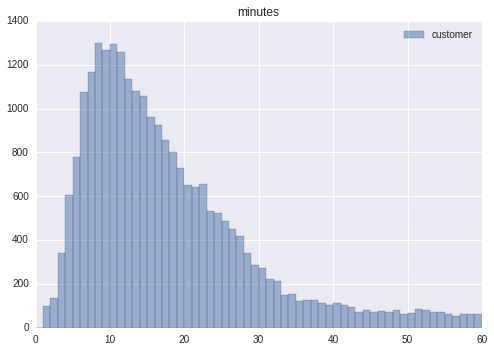

In [8]:
# plot the distribution of trip time, for annual subscriber and short-term customer
normal_trip[normal_trip['Subscription Type'] == 'Subscriber'].hist('minutes',bins=60, range=[0,60], alpha=0.5)
plt.legend(['subscriber'])
normal_trip[normal_trip['Subscription Type'] == 'Customer'].hist('minutes',bins=60, range=[0,60],alpha=0.5)
plt.legend(['customer'])

### Trips on weekdays and weekend

/opt/conda/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


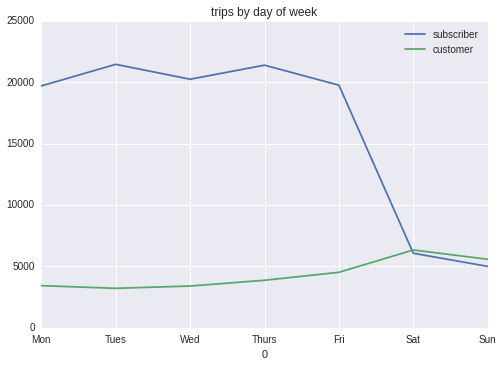

In [9]:
# analyze trips on weekday versus weekend

trips_weekday = []
for i in range(7):
    trips_weekday.append([i, trp[ trp['Start Date'].dt.weekday == i ][trp['Subscription Type'] == 'Subscriber'].shape[0], trp[ trp['Start Date'].dt.weekday == i ][trp['Subscription Type'] == 'Customer'].shape[0] ])
trips_weekday = pd.DataFrame(trips_weekday)

fig = trips_weekday.plot(x=0,y=[1,2])
fig.legend(['subscriber','customer'])
fig.axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
fig.set_title('trips by day of week')

# Collecting external data

### 1. location data from Google Maps API

### 2. public suggestion from
http://suggest.bayareabikeshare.com/page/about

In [24]:
# get elevations grom Google maps API

# def get_elevation(location):
#     url = 'https://maps.googleapis.com/maps/api/elevation/json?locations='
#     url = url + str(location[0]) + ',' + str(location[1])
#     response = requests.get(url)
#     elevation_dict = response.json()
#     return elevation_dict['results'][0]['elevation']


def GetElevs(locs):
    """
    input list of location tuples (lat, long)
    """
    url = 'https://maps.googleapis.com/maps/api/elevation/json?'
    locs_str = '|'.join( [','.join(map(str, loc)) for loc in locs] )
    params = {'locations': locs_str}
    response = requests.get(url, params=params)
    elevation_dict = response.json()
    return elevation_dict

In [25]:
locs = [loc for loc in zip( stations.lat, stations.long )]
elevation_dict = GetElev(locs)
elevations = [e['elevation'] for e in elevation_dict['results']]

# elevations = []
# for loc in zip( stations.lat, stations.long ):
#     elev = get_elevation(loc)
#     elevations.append( elev )
#     time.sleep(10)
#     print elev

stations['elevation'] = pd.DataFrame(elevations)

### Explore if there is preference of downhill trips over uphill trips

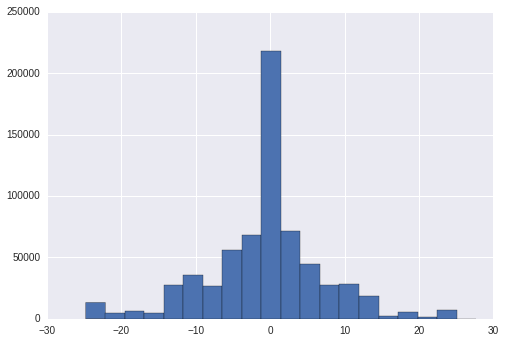

In [27]:
# Distribution of downhill and uphill trips
# join the trip table, adding the start and end elevations, and elevation gain

stations.index = stations['station_id']

trp['start elevation'] = trp.join(stations,on='Start Terminal')['elevation']
trp['end elevation'] = trp.join(stations,on='End Terminal')['elevation']
trp['elevation gain'] = trp['end elevation'] - trp['start elevation']

trp['elevation gain'].hist(bins=20)

In [ ]:
# get location features from Google maps API
def get_place(loc, pagetoken=None):
    url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json'
    params = {'pagetoken':pagetoken, 'location':'37.7817476,-122.4071379', 'radius': 500, 'key': key}
    response = requests.get(url, params=params)
    place_dict = response.json()
    return place_dict   #['results'][0]['elevation']

def radar(keyword, loc, radius, key):
    url = 'https://maps.googleapis.com/maps/api/place/radarsearch/json'
    loc = ','.join( map(str, loc) )
    params = {'keyword': keyword, 'location': loc, 'radius': radius, 'key': key}
#     response = requests.get(url, params=params)
    response = session.get(url, params=params)
    place_dict = response.json()
    return place_dict

def placedetail(placeid):
    url = 'https://maps.googleapis.com/maps/api/place/details/json'
    params = {'placeid': placeid, 'key': key}
    response = requests.get(url, params=params)
    place_dict = response.json()
    return place_dict   #['results'][0]['elevation']


# easy to be denied
def futureElevation(locs, key):
    url = 'https://maps.googleapis.com/maps/api/elevation/json?'
    session = FuturesSession(max_workers=20)
    params_list = []
    for loc in locs:
        loc_str = ','.join( map(str, loc) )
        params = {'locations': loc_str, 'key': key}
        params_list.append(params)
    futures = [session.get(url, params=params) for params in params_list]
    responses = [future.result() for future in futures]
    dicts = [response.json() for response in responses]
    return dicts

In [ ]:
# tests


# places = []
# for loc in zip( stations.lat, stations.long ):
#     elev = get_elevation(loc)
#     elevations.append( elev )
#     time.sleep(10)
#     print elev


# pagetoken = 'CoQC8wAAAMu7YnfnXbQOD3fH5yiww__3T6rVGhkxcMf4Jrx8K8ADkr6BtG4oZmO5QGpCU35b3nNY4jDMAEYX1xKnr7RKjdVGu3MO011AaMdhTFhnUNVI5WBPmiRGafmrThpZGqQZWfPB8gNQLOhSJhm8kH1yZ9rwXaJ-bmyaUHge_9I-b6GrHq0pHX4yXjfkrPtEbm6p7rSpAkIFwv-mIGewBqANCIzvkY1kRw1mBWWDkhBHFY-hKYawt6mb07aTov9k4g36f6nhjr2KFLXZ7NPXQF8FHpo_qrN_D30nE5607F6kDmnLaei8_VmDF_g1ieQyIRXhnRS7C7GwG1im9IsqjrX8NOgSEB6B_2zqwFL2OdbwScSzqDgaFM24Zs-R3b-_9rb8rt7IfcrTe7X3'
# place = get_place([0,0],pagetoken)
# pd.io.json.json_normalize(place)
# print place.keys()
# place['results']

# def allplaces(loc,raius=50):
    
#     return places

# loc = [0,0]
# results = []
# pagetoken = None
# while pagetoken != 'done':
#     response =  get_place(loc, pagetoken)
# #     print len(response['results'])
#     results.extend( response['results'] )
#     if response.has_key('next_page_token'):
#         pagetoken = response['next_page_token']
#     else:
#         pagetoken = 'done'
#     print pagetoken

# len(results)
# loc = [0,0]              
# search = radar(loc)
# print len(search['results'])
# print search['results']
# placedetail('ChIJN-dFBoaAhYAR8cYslWhgUJk')['result']


# loc = tuple(df.ix[1,1:3])
# loc = (37.7817476,  -122.4071379)
# radius = 300
# keyword = 'museum'
# print loc
# search = radar(keyword, loc, radius, key)
# print len( search['results'] )


# session = FuturesSession(max_workers=50)
# url = 'https://maps.googleapis.com/maps/api/place/radarsearch/json'
# params = {'keyword': keyword, 'location': loc, 'radius': radius, 'key': key}
# response = session.get(url, params = params)
# r1 = response.result()
# r1.json()

In [ ]:
with open('data/suggestions.csv', 'r') as f:
    df = pd.read_csv(f)
    
with open('secret/key', 'r') as f:
    key = f.read().replace('\n', '')

### collect locations features for stations from Google Maps API

In [ ]:
# collect locations features for stations

def futureRadar(df, keyword, radius, key):
    url = 'https://maps.googleapis.com/maps/api/place/radarsearch/json'
    session = FuturesSession(max_workers=40)
    params_list = []
    for i in df.itertuples(index = False):
        loc = ','.join( map(str, i[2:4]) )
        params = {'keyword': keyword, 'location': loc, 'radius': radius, 'key': key}
        params_list.append(params)
    futures = [session.get(url, params=params) for params in params_list]
    responses = [future.result() for future in futures]
    dicts = [response.json() for response in responses]
    return dicts

keywords = ['train', 'bus', 'food', 'shopping', 'park', 'school']
radius = 300

session = FuturesSession(max_workers=50)
for keyword in keywords:
    dicts = futureRadar(stations, keyword, radius, key)
    stations[keyword] = [len(i['results']) for i in dicts]
    
# stations.to_csv('data/station_counts.csv')

### generate grid points for prediction 

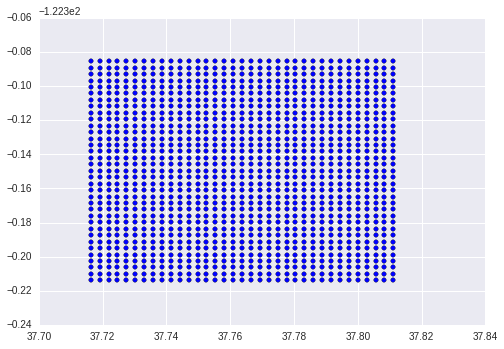

In [44]:
# generate a grid representing SF, used for prediction
def GenGrid(lowerleft, upperright, npt):
    lat = np.linspace(lowerleft[0], upperright[0], npt)
    lng = np.linspace(lowerleft[1], upperright[1], npt)
    latv, lngv = np.meshgrid(lat, lng)
    locs = zip(latv.reshape(npt**2), lngv.reshape(npt**2))
    return locs

lowerleft = (37.71626, -122.513951)
upperright = (37.811164, -122.385373)
locs = GenGrid(lowerleft,upperright,35)

# visualize
x = [loc[0] for loc in locs]
y = [loc[1] for loc in locs]
plt.scatter(x,y)

In [ ]:
# collect locations features for grid points

def futureRadar(locs, keyword, radius, key):
    url = 'https://maps.googleapis.com/maps/api/place/radarsearch/json'
    session = FuturesSession(max_workers=40)
    params_list = []
    for loc in locs:
        loc_str = ','.join( map(str, loc) )
        params = {'keyword': keyword, 'location': loc_str, 'radius': radius, 'key': key}
        params_list.append(params)
    futures = [session.get(url, params=params) for params in params_list]
    responses = [future.result() for future in futures]
    dicts = [response.json() for response in responses]
    return dicts

keywords = ['train', 'bus', 'food', 'shopping', 'park', 'school']
radius = 300

features = {}
for keyword in keywords:
    dicts = futureRadar(locs, keyword, radius, key)
    features[keyword] = [len(i['results']) for i in dicts]
    
elevations = []
for loc in locs:
    elev = get_elevation(loc)
    elevations.append( elev )
    time.sleep(10)
    
features['elevation'] = elevations

In [ ]:
grid_df = pd.DataFrame(features)

lat = [loc[0] for loc in locs]
lng = [loc[1] for loc in locs]
grid_df['lat'] = lat
grid_df['lng'] = lng

with open('data/grid.csv', 'w') as f:
    grid_df.to_csv(f, index=False)

### collect public suggestion data

In [49]:
# save all jsons to disk
url = 'http://suggest.bayareabikeshare.com/api/places'
pages = range(1,48)

for page in pages: 
    payload = {'page': page, 'include_submissions': 'false'}
    response = requests.get(url,payload)
    st_json = response.json()
    with open('data/suggestion-json/page'+str(page),'w') as f:
        json.dump(st_json, f)

In [ ]:
# parse out infomation from json, return a namedtuple
def parseJson(st_json):
    stationBasic = namedtuple('stationBasic', ['stid','lat','lng','weight'])
    stationBasics = []
    for i in range(len(st_json['features'])):
        stid = st_json['features'][i]['id']
        lat = st_json['features'][i]['geometry']['coordinates'][1]
        lng = st_json['features'][i]['geometry']['coordinates'][0]
        if st_json['features'][i]['properties']['submission_sets'].has_key('support') == True:
            weight = st_json['features'][i]['properties']['submission_sets']['support']['length']
        else:
            weight = 0
        stationBasics.append( stationBasic(stid = stid, lat = lat, lng = lng, weight = weight) )
    return stationBasics

# test = st_json
# testvalue = parseJson(test)
# test if has valid supports
# df = pd.DataFrame(result)
# df[3].value_counts()
# testvalue

In [ ]:
# read suggestions in jsons and parse out the needed data
pages = range(1,48)

parsed = []
for page in pages: 
    filename = 'data/suggestion-json/page' + str(page)
    with open(filename, 'r') as f:
        st_json = json.load(f)
#         print len(parseJson(st_json))
        parsed.extend( parseJson(st_json) )
        
columns = ['stid','lat','lng','weight']
df  = pd.DataFrame(parsed, columns=['stid','lat','lng','weight'])
df['weight'].sum()
df['lng'].describe()

df.to_csv('data/suggestions.csv',index = False)